In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rdkit xgboost lightgbm catboost --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_parquet('/content/drive/MyDrive/train_df_long_dt.parquet')

In [ ]:
sampled_data = train_df.groupby('protein_names').apply(lambda x: x.sample(n=20, random_state=42))

# Reset index to flatten the DataFrame after grouping
sampled_data = sampled_data.reset_index(drop=True)
sampled_data.to_csv('/content/drive/MyDrive/sampled_data.csv', index=False)

In [ ]:
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np
#from tqdm.notebook import tqdm  # For progress bar

# OneHotEncode the 'protein_name' column
onehot_encoder = OneHotEncoder(sparse_output=False)  # Use sparse=False for dense matrix
onehot_encoder

OneHotEncoder(sparse_output=False)

In [ ]:
protein_onehot_train = onehot_encoder.fit_transform(train_df['protein_names'].values.reshape(-1, 1))

In [ ]:
import numpy as np

# Convert lists to NumPy arrays
ecfp_array = np.array(train_df['ecfp'].tolist(), dtype=np.float32)
protein_array = np.array(protein_onehot_train.tolist(), dtype=np.float32)
binds_array = np.array(train_df['binds'].tolist(), dtype=np.int8)

# Combine arrays
X = np.hstack((ecfp_array, protein_array))
y = binds_array

print("X:", X)
print("y:", y)

X: [[0. 1. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]]
y: [0 0 0 ... 1 1 0]


In [ ]:
import os
import pickle

save_directory = '/content/drive/MyDrive/DS5500/'
os.makedirs(save_directory, exist_ok=True)

# Save files
with open(os.path.join(save_directory, 'X.pkl'), 'wb') as f:
    pickle.dump(X, f)

with open(os.path.join(save_directory, 'y.pkl'), 'wb') as f:
    pickle.dump(y, f)

print(f"Files saved to: {save_directory}")


In [ ]:
load pickle files
import pickle
import os

# Specify the directory and file name
save_directory = '/content/drive/MyDrive/DS5500/'  # Adjust to your specific location
file_name_X = 'X.pkl'  # Replace with the actual file name if different
file_name_y = 'y.pkl'  # Replace with the actual file name if different

# Load the pickle files
with open(os.path.join(save_directory, file_name_X), 'rb') as f:
    X = pickle.load(f)

with open(os.path.join(save_directory, file_name_y), 'rb') as f:
    y = pickle.load(f)

# Print confirmation and details
print(f"Loaded X with shape: {len(X)} rows")
print(f"Loaded y with shape: {len(y)} rows")


Loaded X with shape: 10191006 rows
Loaded y with shape: 10191006 rows


In [ ]:
print(len(X))
print(len(y))

10191006
10191006


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train)
len(y_train)

8152804

In [ ]:
# Convert y_train to a NumPy array for calculations
y_train = np.array(y_train)

# Calculate class imbalance ratio
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Output the scale_pos_weight
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

Scale Pos Weight: 7.55


## **Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth': [10, 20, 30, 50],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'gamma': [0, 1, 5, 10],
    'reg_alpha': [0, 1, 10],
    'reg_lambda': [1, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        objective='binary:logistic',
        n_jobs=-1,
        tree_method='hist',
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to test
    scoring='average_precision',
    cv=2,
    verbose=1
)

random_search.fit(X_train, y_train)
print(f"Best Params: {random_search.best_params_}")
print(f"Best mAP: {random_search.best_score_}")


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from catboost import CatBoostClassifier
import numpy as np
cbc = CatBoostClassifier()
param_dist = { "learning_rate": np.linspace(0,0.2,5),
               "max_depth": randint(3, 10)}

#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbc , param_dist, scoring='accuracy', cv =5)

#Fit the model
rscv.fit(X_train,y_train)

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

Streaming output truncated to the last 5000 lines.
2:	learn: 0.4627399	total: 580ms	remaining: 3m 12s
3:	learn: 0.4215097	total: 771ms	remaining: 3m 12s
4:	learn: 0.3908719	total: 958ms	remaining: 3m 10s
5:	learn: 0.3660655	total: 1.13s	remaining: 3m 7s
6:	learn: 0.3471080	total: 1.32s	remaining: 3m 7s
7:	learn: 0.3325035	total: 1.5s	remaining: 3m 5s
8:	learn: 0.3213903	total: 1.67s	remaining: 3m 4s
9:	learn: 0.3125403	total: 1.96s	remaining: 3m 14s
10:	learn: 0.3050067	total: 2.14s	remaining: 3m 12s
11:	learn: 0.2991078	total: 2.31s	remaining: 3m 10s
12:	learn: 0.2942709	total: 2.49s	remaining: 3m 8s
13:	learn: 0.2900106	total: 2.66s	remaining: 3m 7s
14:	learn: 0.2854309	total: 2.85s	remaining: 3m 7s
15:	learn: 0.2819950	total: 3.03s	remaining: 3m 6s
16:	learn: 0.2798640	total: 3.21s	remaining: 3m 5s
17:	learn: 0.2773694	total: 3.39s	remaining: 3m 4s
18:	learn: 0.2750330	total: 3.55s	remaining: 3m 3s
19:	learn: 0.2735744	total: 3.73s	remaining: 3m 2s
20:	learn: 0.2717304	total: 3.91s	

In [ ]:
from re import VERBOSE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, average_precision_score
from sklearn.model_selection import cross_val_score
import joblib
import os

# Define selected models
#logistic_regression = LogisticRegression(class_weight='balanced', max_iter=200)
logistic_regression = LogisticRegression( penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    C=1.0,
    max_iter=200,
    random_state=42
)

decision_tree = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=105)

random_forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=30,
    class_weight="balanced",
    random_state=105,
    n_jobs=-1
)

xgboost = XGBClassifier(
    n_estimators=100,
    max_depth=250,
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.1,
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    tree_method='hist'
)


# lgbm = LGBMClassifier(
#     n_estimators=50,
#     max_depth=50,
#     scale_pos_weight=scale_pos_weight,
#     learning_rate=0.1
# )
lgbm = LGBMClassifier(boosting_type='gbdt',
                      bagging_freq = 5,
                      verbose = 0,
                      #device = 'gpu',
                      num_leaves=31,
                      max_depth=250,
                      learning_rate=0.1,
                      n_estimators=100)

catboost = CatBoostClassifier(
    iterations=50,
    depth=8,
    learning_rate=0.2,
    verbose=0,
    scale_pos_weight=scale_pos_weight
)

# Define directory to save models
save_directory = "/content/drive/MyDrive/DS5500/saved_models/"
os.makedirs(save_directory, exist_ok=True)

# Train and save the models
def train_save_evaluate_model(name, model, X_train, y_train, X_val, y_val, save_directory):
    try:
        print(f"\nTraining {name}...")
        # Train the model
        model.fit(X_train, y_train)

        # Save the model
        model_path = os.path.join(save_directory, f"{name.replace(' ', '_')}.pkl")
        joblib.dump(model, model_path)
        print(f"Model saved to {model_path}")

        # Predictions
        pred_model = model.predict(X_val)
        pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Metrics
        accuracy = accuracy_score(y_val, pred_model)
        weighted_map = (
            average_precision_score(y_val, pred_proba, average='weighted') if pred_proba is not None else None
        )

        # Classification report
        report = classification_report(y_val, pred_model)

        # Display results
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.2f}")
        if weighted_map is not None:
            print(f"Weighted mAP: {weighted_map:.2f}")
        print(report)

    except Exception as e:
        print(f"Model: {name} encountered an error: {str(e)}")


In [ ]:
train_save_evaluate_model("CatBoost", catboost, X_train, y_train, X_val, y_val, save_directory)


Training CatBoost...
Model saved to /content/drive/MyDrive/DS5500/saved_models/CatBoost.pkl
Model: CatBoost
Accuracy: 0.91
Weighted mAP: 0.81
              precision    recall  f1-score   support

           0       0.98      0.92      0.95   1799365
           1       0.59      0.85      0.70    238837

    accuracy                           0.91   2038202
   macro avg       0.78      0.89      0.82   2038202
weighted avg       0.93      0.91      0.92   2038202



In [ ]:
train_save_evaluate_model("xgboost", xgboost, X_train, y_train, X_val, y_val, save_directory)


Training xgboost...
Model saved to /content/drive/MyDrive/DS5500/saved_models/xgboost.pkl
Model: xgboost
Accuracy: 0.96
Weighted mAP: 0.90
              precision    recall  f1-score   support

           0       0.98      0.97      0.97   1799365
           1       0.80      0.82      0.81    238837

    accuracy                           0.96   2038202
   macro avg       0.89      0.90      0.89   2038202
weighted avg       0.96      0.96      0.96   2038202



In [ ]:
train_save_evaluate_model("lgbm", lgbm, X_train, y_train, X_val, y_val, save_directory)


Training lgbm...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Model saved to /content/drive/MyDrive/DS5500/saved_models/lgbm.pkl
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Model: lgbm
Accuracy: 0.94
Weighted mAP: 0.83
              precision    recall  f1-score   support

           0       0.95      0.99      0.97   1799365
           1       0.86      0.60      0.71    238837

    accuracy                           0.94   2038202
   macro avg       0.91      0.79      0.84   2038202
weighted avg       0.94      0.94      0.94   2038202



Loaded Catboost model from /content/drive/MyDrive/DS5500/saved_models/CatBoost.pkl


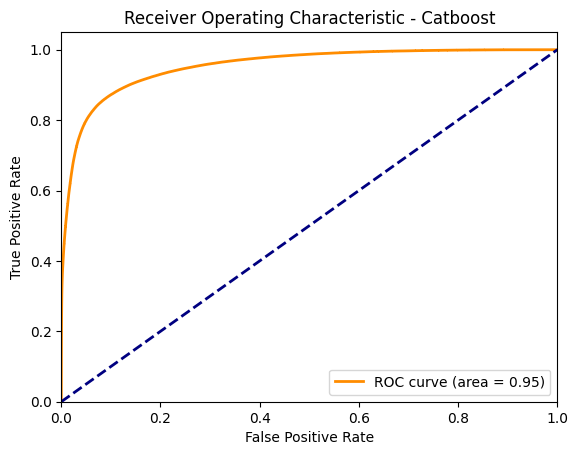

Accuracy: 0.91


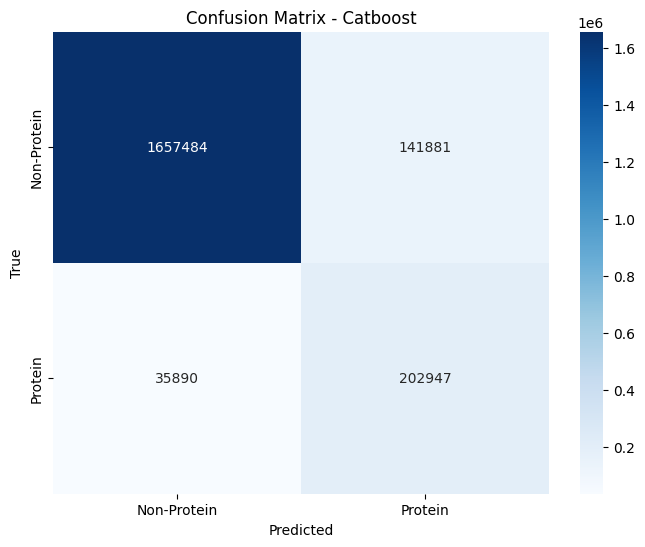

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95   1799365
           1       0.59      0.85      0.70    238837

    accuracy                           0.91   2038202
   macro avg       0.78      0.89      0.82   2038202
weighted avg       0.93      0.91      0.92   2038202



In [ ]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, confusion_matrix, classification_report
)

# Define file path
model_path = "/content/drive/MyDrive/DS5500/saved_models/CatBoost.pkl"

# Load the saved Catboost model
try:
    model = joblib.load(model_path)
    print(f"Loaded Catboost model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise

# Predictions
y_pred = model.predict(X_val)

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Catboost')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Catboost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))


Loaded XGBoost model from /content/drive/MyDrive/DS5500/saved_models/xgboost.pkl


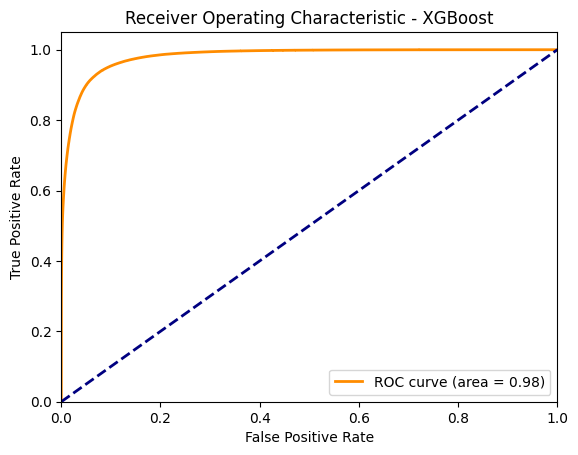

Accuracy: 0.96


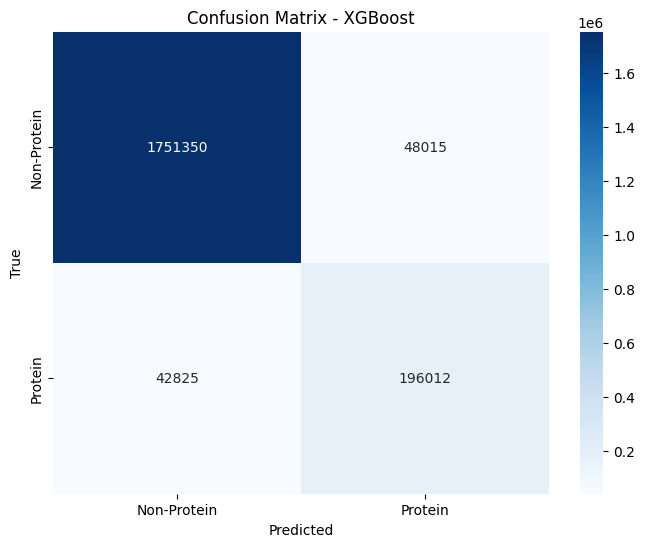

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97   1799365
           1       0.80      0.82      0.81    238837

    accuracy                           0.96   2038202
   macro avg       0.89      0.90      0.89   2038202
weighted avg       0.96      0.96      0.96   2038202



In [ ]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, confusion_matrix, classification_report
)

# Define file path
model_path = "/content/drive/MyDrive/DS5500/saved_models/xgboost.pkl"

# Load the saved Catboost model
try:
    model = joblib.load(model_path)
    print(f"Loaded XGBoost model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise

# Predictions
y_pred = model.predict(X_val)

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))


Loaded LightGBM model from /content/drive/MyDrive/DS5500/saved_models/lgbm.pkl
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


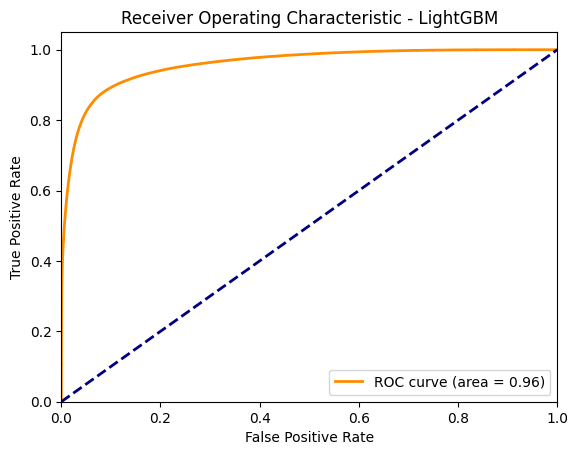

Accuracy: 0.94


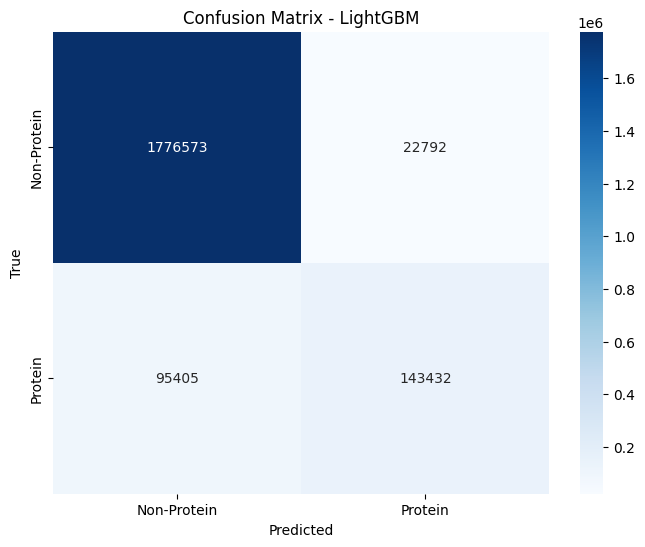

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97   1799365
           1       0.86      0.60      0.71    238837

    accuracy                           0.94   2038202
   macro avg       0.91      0.79      0.84   2038202
weighted avg       0.94      0.94      0.94   2038202



In [ ]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, confusion_matrix, classification_report
)

# Define file path
model_path = "/content/drive/MyDrive/DS5500/saved_models/lgbm.pkl"

# Load the saved Catboost model
try:
    model = joblib.load(model_path)
    print(f"Loaded LightGBM model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise

# Predictions
y_pred = model.predict(X_val)

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LightGBM')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LightGBM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter space
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None] + list(range(10, 50, 10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Weighted mAP for the Ensemble: 0.88
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


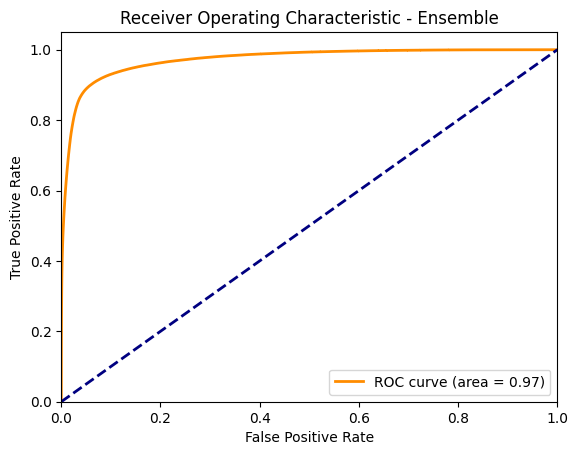

Accuracy: 0.96


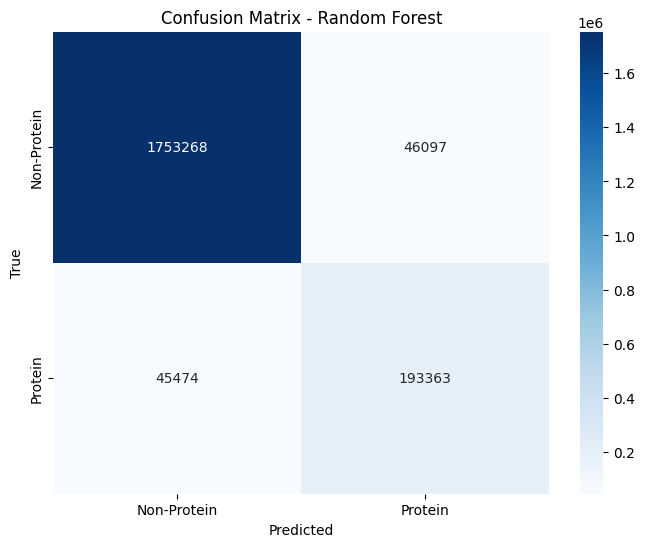

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97   1799365
           1       0.81      0.81      0.81    238837

    accuracy                           0.96   2038202
   macro avg       0.89      0.89      0.89   2038202
weighted avg       0.96      0.96      0.96   2038202



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

# Weights based on Weighted mAP
weights = weights = {
    "XGBoost": 0.354,
    "LGBM": 0.319,
    "CatBoost": 0.327
}


# Load trained models
models = {
    "XGBoost": joblib.load("/content/drive/MyDrive/DS5500/saved_models/XGBoost.pkl"),
    "LGBM": joblib.load("/content/drive/MyDrive/DS5500/saved_models/LGBM.pkl"),
    "CatBoost": joblib.load("//content/drive/MyDrive/DS5500/saved_models/CatBoost.pkl")
}

# Aggregate weighted probabilities
def weighted_ensemble_predict_proba(models, weights, X_val):
    # Determine the number of classes from one of the models
    n_classes = models["XGBoost"].n_classes_
    # Initialize weighted probabilities
    weighted_probas = np.zeros((X_val.shape[0], n_classes))
    for name, model in models.items():
        proba = model.predict_proba(X_val)
        weighted_probas += weights[name] * proba
    return weighted_probas

# Final predictions
def weighted_ensemble_predict(models, weights, X_val):
    weighted_probas = weighted_ensemble_predict_proba(models, weights, X_val)
    return np.argmax(weighted_probas, axis=1)

# Compute Weighted Mean Average Precision (mAP)
def compute_weighted_map(models, weights, X_val, y_val):
    # Get the weighted probabilities
    weighted_probas = weighted_ensemble_predict_proba(models, weights, X_val)
    # Use only the probability for the positive class
    proba_positive_class = weighted_probas[:, 1]
    # Compute Weighted mAP
    weighted_map = average_precision_score(y_val, proba_positive_class, average='weighted')
    return weighted_map

# Get weighted predictions
y_pred = weighted_ensemble_predict(models, weights, X_val)


# Compute Weighted mAP
weighted_map = compute_weighted_map(models, weights, X_val, y_val)
print(f"Weighted mAP for the Ensemble: {weighted_map:.2f}")

# ROC Curve
proba = weighted_ensemble_predict_proba(models, weights, X_val)
fpr, tpr, _ = roc_curve(y_val, proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - Ensemble")
plt.legend(loc="lower right")
plt.show()


# Evaluate the accuracy of ensemble model
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))


In [ ]:

import numpy as np

# Generate meta-features (predictions from base models)
X_meta_train = np.column_stack([
    models["XGBoost"].predict_proba(X_train)[:, 1],  # Probability for class 1
    models["LGBM"].predict_proba(X_train)[:, 1],
    models["CatBoost"].predict_proba(X_train)[:, 1]
])

# Generate meta-features for validation data
X_meta_val = np.column_stack([
    models["XGBoost"].predict_proba(X_val)[:, 1],
    models["LGBM"].predict_proba(X_val)[:, 1],
    models["CatBoost"].predict_proba(X_val)[:, 1]
])

# The target remains the same
y_meta_train = y_train
y_meta_val = y_val


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [ ]:

# Define the meta-model with multi-threading
meta_model = LogisticRegression(solver='saga', max_iter=200, n_jobs=-1)

# Train the meta-model
meta_model.fit(X_meta_train, y_meta_train)

# Save the meta-model
joblib.dump(meta_model, '/content/drive/MyDrive/DS5500/saved_models/meta_model.pkl')
print("Meta-model saved successfully.")

Meta-model saved successfully.


In [ ]:

 # Predictions
pred_model = meta_model.predict(X_meta_val)
pred_proba = meta_model.predict_proba(X_meta_val)[:, 1] if hasattr(model, "predict_proba") else None

# Metrics
accuracy = accuracy_score(y_meta_val, pred_model)
weighted_map = (
average_precision_score(y_meta_val, pred_proba, average='weighted') if pred_proba is not None else None
)

# Classification report
report = classification_report(y_meta_val, pred_model)

# Display results
print(f"Model: Ensemble model using stacking")
print(f"Accuracy: {accuracy:.2f}")
if weighted_map is not None:
  print(f"Weighted mAP: {weighted_map:.2f}")
  print(report)

Model: Ensemble model using stacking
Accuracy: 0.96
Weighted mAP: 0.87
              precision    recall  f1-score   support

           0       0.96      0.99      0.97   1799365
           1       0.88      0.72      0.79    238837

    accuracy                           0.96   2038202
   macro avg       0.92      0.85      0.88   2038202
weighted avg       0.95      0.96      0.95   2038202



In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import joblib

# Load pre-trained models
xgb_model = joblib.load("/content/drive/MyDrive/DS5500/saved_models/XGBoost.pkl")
lgbm_model = joblib.load("/content/drive/MyDrive/DS5500/saved_models/LGBM.pkl")
catboost_model = joblib.load("/content/drive/MyDrive/DS5500/saved_models/CatBoost.pkl")

# Create StackingClassifier
stack = StackingClassifier(
    estimators=[
        ("XGBoost", xgb_model),
        ("LGBM", lgbm_model),
        ("CatBoost", catboost_model),
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)

# Train ensemble
stack.fit(X_train, y_train)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [ ]:

 # Predictions
pred_model = stack.predict(X_val)
pred_proba = stack.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

# Metrics
accuracy = accuracy_score(y_val, pred_model)
weighted_map = (
average_precision_score(y_val, pred_proba, average='weighted') if pred_proba is not None else None
)

# Classification report
report = classification_report(y_val, pred_model)

# Display results
print(f"Model: Ensemble model using stacking")
print(f"Accuracy: {accuracy:.2f}")
if weighted_map is not None:
  print(f"Weighted mAP: {weighted_map:.2f}")
  print(report)

**Exploring RINGS**


In [ ]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import pandas as pd

# Assuming you already have a dataframe `df` with a column 'smiles' containing SMILES strings
def check_rings(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Check for rings in the molecule
        has_rings = mol.GetRingInfo().NumRings() > 0
        # Check for aromatic rings in the molecule
        has_aromatic_rings = any(atom.GetIsAromatic() for atom in mol.GetAtoms() if atom.IsInRing())
        return pd.Series([has_rings, has_aromatic_rings])
    else:
        return pd.Series([False, False])

# Apply the function to the dataframe
train_df[['has_rings', 'has_aromatic_rings']] = train_df['molecule_smiles'].apply(check_rings)

# Display the updated dataframe
print(train_df.head())


                               buildingblock1_smiles  \
0  O=C(N[C@@H](Cc1ccc(F)cc1)C(=O)O)OCC1c2ccccc2-c...   
1  COc1cc(NC(=O)OCC2c3ccccc3-c3ccccc32)c(C(=O)O)c...   
2      O=C(Nc1ccc(C(=O)O)cc1O)OCC1c2ccccc2-c2ccccc21   
3  O=C(O)[C@H]1Cc2ccccc2CN1C(=O)OCC1c2ccccc2-c2cc...   
4  O=C(N[C@@H](Cc1c(F)c(F)c(F)c(F)c1F)C(=O)O)OCC1...   

       buildingblock2_smiles     buildingblock3_smiles  \
0    COc1cccc(-c2cc(N)on2)c1   Cl.Cl.NCCC(=O)Nc1ccncc1   
1       NCc1cccc(C(F)(F)F)n1  Cl.Cl.NCc1nccc2[nH]ccc12   
2         C=C(C)C(=O)NCCN.Cl             CSc1nnc(CN)s1   
3      Nc1cccnc1[N+](=O)[O-]           CC1CC(CN)C(C)O1   
4  CN1C(=O)Cc2cc(CN)ccc21.Cl     Cl.Cl.NCc1ccc2scnc2c1   

                                     molecule_smiles protein_names  binds  \
0  COc1cccc(-c2cc(Nc3nc(NCCC(=O)Nc4ccncc4)nc(N[C@...          BRD4      0   
1  COc1cc(Nc2nc(NCc3cccc(C(F)(F)F)n3)nc(NCc3nccc4...          BRD4      0   
2  C=C(C)C(=O)NCCNc1nc(NCc2nnc(SC)s2)nc(Nc2ccc(C(...          BRD4      0   
3  CC1